(dl/02-optim)=
# Gradient Optimization

Recall that we can visualize $\mathcal{L}_{\mathcal{D}}(\boldsymbol{\Theta})$ as a surface ({numref}`02-loss-surface`). Gradient descent (GD) finds the minimum by locally moving in the direction of greatest decrease in loss ({numref}`02-gradient-descent-1d`). The step size in GD depends on
the learning rate that has to be tuned well: a too large learning rate can result in overshooting the minimum and causing oscillations, while a too small learning rate can lead to slow convergence or getting stuck in local minima or plateaus. In this chapter, we will discuss gradient descent with **momentum**, as well as adaptive momentum with **Adam** {cite}`adam` and **RMSProp** {cite}`rmsprop`, which adjust the learning rate during training and dampen oscillations to improve optimization performance.

In [1]:
!rm chapter.py; touch chapter.py

<br>

```{figure} ../../../img/nn/02-loss-surface.png
---
name: 02-loss-surface
width: 60%
align: center
---
Loss surface for a model with two weights. [Source](https://cs182sp21.github.io/static/slides/lec-4.pdf)
```

```{figure} ../../../img/nn/02-gradient-descent-1d.png
---
name: 02-gradient-descent-1d
width: 60%
align: center
---
Gradient descent in 1-dimension. 
Next step moves opposite to the direction of the slope. Moreover, step size is scaled
based on the magnitude of the slope. [Source](https://cs182sp21.github.io/static/slides/lec-4.pdf)
```

## Optimizer template class

To experiment with GD algorithms, we create a template class. The template implements a method for zeroing out the gradients. 
The only method that typically needs to be changed is `update_param` which contains the algorithm for updating parameters.

In [2]:
%%save
import torch
import torch.nn as nn

class OptimizerBase:
    def __init__(self, params: list, lr: float):
        self.params = params
        self.lr = lr

    def zero_grad(self):
        for p in self.params:
            if p.grad is None:
                continue
            p.grad.detach_()
            p.grad.zero_()

    @torch.no_grad()
    def step(self):
        for p in self.params:
            if p.grad is None:
                continue
            self.update_param(p)

    def update_param(self, p):
        raise NotImplementedError

import torch
import torch.nn as nn

class OptimizerBase:
    def __init__(self, params: list, lr: float):
        self.params = params
        self.lr = lr

    def zero_grad(self):
        for p in self.params:
            if p.grad is None:
                continue
            p.grad.detach_()
            p.grad.zero_()

    @torch.no_grad()
    def step(self):
        for p in self.params:
            if p.grad is None:
                continue
            self.update_param(p)

    def update_param(self, p):
        raise NotImplementedError

Gradient descent can be implemented with the template as follows:

In [3]:
%%save

class GD(OptimizerBase):
    def __init__(self, params, lr):
        super().__init__(params, lr)

    def update_param(self, p):
        p += -self.lr * p.grad

class GD(OptimizerBase):
    def __init__(self, params, lr):
        super().__init__(params, lr)

    def update_param(self, p):
        p += -self.lr * p.grad

We will test with the following synthetic loss surface (i.e. not generated with data):

In [4]:
%%save

# https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial4/Optimization_and_Initialization.html
def pathological_loss(w0, w1):
    l1 = torch.tanh(w0) ** 2 + 0.01 * torch.abs(w1)
    l2 = torch.sigmoid(w1)
    return l1 + l2

# https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial4/Optimization_and_Initialization.html
def pathological_loss(w0, w1):
    l1 = torch.tanh(w0) ** 2 + 0.01 * torch.abs(w1)
    l2 = torch.sigmoid(w1)
    return l1 + l2

In [5]:
%%save
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
from mpl_toolkits.mplot3d import Axes3D 
backend_inline.set_matplotlib_formats('svg')


def plot_surface(ax, f, title="", x_min=-5, x_max=5, y_min=-5, y_max=5, N=50):
    x = np.linspace(x_min, x_max, N)
    y = np.linspace(y_min, y_max, N)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)
    for i in range(N):
        for j in range(N):
            Z[i, j] = f(torch.tensor(X[i, j]), torch.tensor(Y[i, j]))
    
    ax.plot_surface(X, Y, Z, cmap='viridis')
    ax.set_xlabel(f'$w_0$')
    ax.set_ylabel(f'$w_1$')
    ax.set_title(title)
    

def plot_contourf(ax, f, w_hist, color, title="", levels=20, x_min=-5, x_max=5, y_min=-5, y_max=5, N=50, **kw):
    x = np.linspace(x_min, x_max, N)
    y = np.linspace(y_min, y_max, N)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)
    for i in range(N):
        for j in range(N):
            Z[i, j] = f(torch.tensor(X[i, j]), torch.tensor(Y[i, j]))

    for t in range(1, len(w_hist)):
        ax.plot([w_hist[t-1][0], w_hist[t][0]], [w_hist[t-1][1], w_hist[t][1]], color=color)

    ax.contourf(X, Y, Z, levels=levels, cmap='viridis')
    ax.scatter(w_hist[:, 0], w_hist[:, 1], marker='o', s=5, facecolors=color, color=color, **kw)
    ax.set_title(title)
    ax.set_xlabel(f'$w_0$')
    ax.set_ylabel(f'$w_1$')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
from mpl_toolkits.mplot3d import Axes3D 
backend_inline.set_matplotlib_formats('svg')


def plot_surface(ax, f, title="", x_min=-5, x_max=5, y_min=-5, y_max=5, N=50):
    x = np.linspace(x_min, x_max, N)
    y = np.linspace(y_min, y_max, N)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)
    for i in range(N):
        for j in range(N):
            Z[i, j] = f(torch.tensor(X[i, j]), torch.tensor(Y[i, j]))
    
    ax.plot_surface(X, Y, Z, cmap='viridis')
    ax.set_xlabel(f'$w_0$')
    ax.set_ylabel(f'$w_1$')
    ax.set_title(title)
    

def plot_contourf(ax, f, w_hist, color, title="", levels=20, x_min=-5, x_max=5, y_min=-5, y_max=5, N=50, **kw):
    x = np.linspace(x_min, x_max, N)
    y = np.linspace(y_min, y_max, N)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)
    for i in range(N):
        for j in range(N):
            Z[i, j] = f(torch.tensor(X[i, j]), torch.tensor(Y[i, j]))

    for t in range(1, len(w_hist)):
        ax.plot([w_hist[t-1][0], w_hist[t][0]], [w_hist[t-1][1], w_hist[t][1]], color=color)

    ax.contourf(X, Y, Z, levels=levels, cmap='viridis')
    ax.scatter(w_hist[:, 0], w_hist[:, 1], marker='o', s=5, facecolors=color, color=color, **kw)
    ax.set_title(title)
    ax.set_xlabel(f'$w_0$')
    ax.set_ylabel(f'$w_1$')

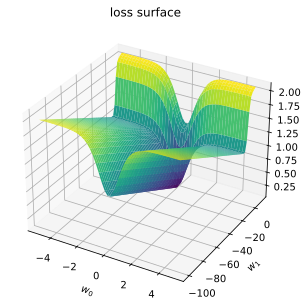

In [6]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
plot_surface(ax, pathological_loss, x_min=-5, x_max=5, y_min=-100, y_max=10, title="loss surface")

The following optimization algorithm purely operates on the loss surface as a function of weights. 
It starts with initial weights `w_init`, then updates this weight iteratively by computing the
gradient of the loss function. The weight update step depends on the particular optimizer class used.

In [7]:
%%save

def train_curve(
    optim: OptimizerBase, 
    optim_params: dict, 
    w_init=[5.0, 5.0], 
    loss_fn=pathological_loss, 
    num_steps=100
):
    """Return trajectory of optimizer through loss surface from init point."""

    w_init = torch.tensor(w_init).float()
    w = nn.Parameter(w_init, requires_grad=True)
    optim = optim([w], **optim_params)
    points = [torch.tensor([w[0], w[1], loss_fn(w[0], w[1])])]
    
    for step in range(num_steps):
        optim.zero_grad()
        loss = loss_fn(w[0], w[1])
        loss.backward()
        optim.step()

        # logging
        with torch.no_grad():
            z = loss.unsqueeze(dim=0)
            points.append(torch.cat([w.data, z]))

    return torch.stack(points, dim=0).numpy()

def train_curve(
    optim: OptimizerBase, 
    optim_params: dict, 
    w_init=[5.0, 5.0], 
    loss_fn=pathological_loss, 
    num_steps=100
):
    """Return trajectory of optimizer through loss surface from init point."""

    w_init = torch.tensor(w_init).float()
    w = nn.Parameter(w_init, requires_grad=True)
    optim = optim([w], **optim_params)
    points = [torch.tensor([w[0], w[1], loss_fn(w[0], w[1])])]
    
    for step in range(num_steps):
        optim.zero_grad()
        loss = loss_fn(w[0], w[1])
        loss.backward()
        optim.step()

        # logging
        with torch.no_grad():
            z = loss.unsqueeze(dim=0)
            points.append(torch.cat([w.data, z]))

    return torch.stack(points, dim=0).numpy()

Gradient descent from the same initial point with different learning rates:

In [8]:
%%save

def plot_gd_steps(ax, optim, optim_params: dict, label_map={}, w_init=[-2.5, 2.5], num_steps=300, **plot_kw):
    label = optim.__name__ + " (" + ", ".join(f"{label_map.get(k, k)}={v}" for k, v in optim_params.items()) + ")"
    path = train_curve(optim, optim_params, w_init=w_init, num_steps=num_steps)
    plot_contourf(ax[0], f=pathological_loss, w_hist=path, x_min=-10, x_max=10, y_min=-10, y_max=10, label=label, zorder=2, **plot_kw)
    ax[1].plot(np.array(path)[:, 2], label=label, color=plot_kw.get("color"), zorder=plot_kw.get("zorder", 1))
    ax[1].set_xlabel("steps")
    ax[1].set_ylabel("loss")
    ax[1].grid(linestyle="dotted", alpha=0.8)
    return path

def plot_gd_steps(ax, optim, optim_params: dict, label_map={}, w_init=[-2.5, 2.5], num_steps=300, **plot_kw):
    label = optim.__name__ + " (" + ", ".join(f"{label_map.get(k, k)}={v}" for k, v in optim_params.items()) + ")"
    path = train_curve(optim, optim_params, w_init=w_init, num_steps=num_steps)
    plot_contourf(ax[0], f=pathological_loss, w_hist=path, x_min=-10, x_max=10, y_min=-10, y_max=10, label=label, zorder=2, **plot_kw)
    ax[1].plot(np.array(path)[:, 2], label=label, color=plot_kw.get("color"), zorder=plot_kw.get("zorder", 1))
    ax[1].set_xlabel("steps")
    ax[1].set_ylabel("loss")
    ax[1].grid(linestyle="dotted", alpha=0.8)
    return path

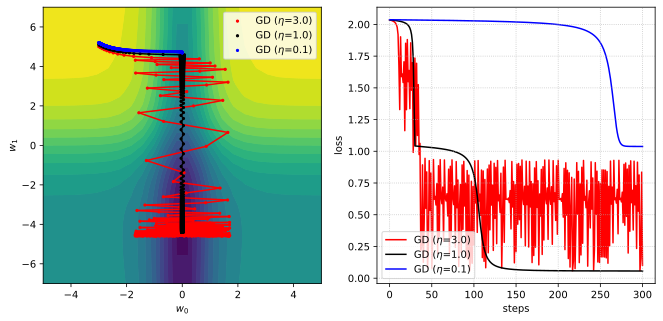

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

plot_gd_steps(ax, optim=GD, optim_params={"lr": 3.0}, w_init=[-3.0, 5.0], label_map={"lr": r"$\eta$"}, color="red")
plot_gd_steps(ax, optim=GD, optim_params={"lr": 1.0}, w_init=[-3.0, 5.1], label_map={"lr": r"$\eta$"}, color="black")
plot_gd_steps(ax, optim=GD, optim_params={"lr": 0.1}, w_init=[-3.0, 5.2], label_map={"lr": r"$\eta$"}, color="blue")

ax[0].set_xlim(-5, 5)
ax[0].set_ylim(-7, 7)
ax[0].legend()
ax[1].legend();

A too large learning rate may oscillate around a minimum, while an optimizer with too small LR can get stuck in a flat region of the surface. Hence, base LR has to be tuned for vanilla GD to work well. Note that the optimal LR value depends on the initial point, so you have to make sure that, at each point of the program, the random seed is being set appropriately.

## References

- [Berkeley CS 182. Lecture 4: Optimization](https://cs182sp21.github.io/static/slides/lec-4.pdf)
- [Escaping from Saddle Points](https://www.offconvex.org/2016/03/22/saddlepoints/)
- [UvA DLC. Tutorial 4: Optimization and Initialization](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial4/Optimization_and_Initialization.html)